In [ ]:
import pandas as pd
import time
import random
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import numpy as np


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep

## Scrape Players Data 

In [11]:
# List of all league-season URLs
leagues = {
    '9': 'Premier League',
    '12': 'La Liga',
    '11': 'Serie A',
    '20': 'Bundesliga',
    '13': 'Ligue 1',
    '10': 'Championship',
    '19': 'Major League Soccer',
    '24': 'Brasileirao',
    '31': 'Liga MX',
    '23': 'Eredivisie',
    '32': 'Primeira Liga',
    '39': 'Liga Profesional',
    '37': 'Belgian Pro League',
    '40': 'Serie B',
    '56': 'Austrian Bundesliga'
}

In [12]:
# Seasons
seasons = [f'{year}-{year+1}' for year in range(2013, 2024)]

In [13]:
# URL template: per-player stats
base_url = 'https://fbref.com/en/comps/{code}/{season}/stats/{season}-{league_name}-Stats'
url_list = []

for code, name in leagues.items():
    for season in seasons:
        league_name_url = name.replace(" ", "-").replace(".", "")
        url = base_url.format(code=code, season=season, league_name=league_name_url)
        url_list.append((name, season, url))

In [8]:
base_url = 'https://fbref.com/en/comps/{code}/{season}/stats/{season}-{league_name}-Stats'
last_season = []

for code, name in leagues.items():
        season = '2024-2025'
        league_name_url = name.replace(" ", "-").replace(".", "")
        url = base_url.format(code=code, season=season, league_name=league_name_url)
        last_season.append((name, season, url))

In [24]:
# --- SELENIUM SETUP ---
options = webdriver.ChromeOptions()
options.add_argument("--headless=new")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)


In [ ]:
# --- SCRAPING LOOP ---
all_data = []

for league, season, url in tqdm(url_list):
    try:
        print(f"\n🔍 Scraping {league} {season}...")

        driver.get(url)
        time.sleep(random.uniform(5, 7))  # Wait for JS to load

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        table = soup.find('table', {'id': 'stats_standard'})
        if table is None:
            print(f"⚠️ No player stats table found at {url}")
            continue

        df = pd.read_html(str(table), header=[0, 1])[0]
        df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
        df.columns = [ col.replace("Unnamed: ", "").split(" ", 1)[-1] if col.startswith("Unnamed: ") else col for col in df.columns ]
        df = df[df['Player'].values != 'Player']  # Remove internal header rows
        df['League'] = league
        df['Season'] = season
        all_data.append(df)

        print(f"✅ {len(df)} players scraped.")
        time.sleep(random.uniform(1, 3))

    except Exception as e:
        print(f"❌ Error scraping {league} {season}: {e}")
        time.sleep(random.uniform(3, 6))

# --- CLEANUP ---
driver.quit()

# --- RESULT ---
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\n🎉 Done! Collected {combined_df.shape[0]} player-season rows across {len(all_data)} tables.")
else:
    print("🚫 No data was scraped.")

In [22]:
combined_df[['Player','League','Season']]

,Player,League,Season
0,Charlie Adam,Premier League,2013-2014
1,Emmanuel Adebayor,Premier League,2013-2014
2,Adrián,Premier League,2013-2014
3,Gabriel Agbonlahor,Premier League,2013-2014
4,Daniel Agger,Premier League,2013-2014
...,...,...,...
79939,Bernhard Zimmermann,Austrian Bundesliga,2023-2024
79940,Jovan Živković,Austrian Bundesliga,2023-2024
79941,Robert Žulj,Austrian Bundesliga,2023-2024
79942,Jan Zwischenbrugger,Austrian Bundesliga,2023-2024


In [23]:
combined_df.loc[combined_df['Player'] == 'Manor Solomon'][['Player','League','Season']]

,Player,League,Season
5336,Manor Solomon,Premier League,2022-2023
5917,Manor Solomon,Premier League,2023-2024
64738,Manor Solomon,Liga Profesional,2018-2019
65131,Manor Solomon,Liga Profesional,2019-2020
65590,Manor Solomon,Liga Profesional,2020-2021
66020,Manor Solomon,Liga Profesional,2021-2022


In [ ]:
last_season_list = []
for league, season, url in tqdm(last_season):
    try:
        print(f"\n🔍 Scraping {league} '2024-2025'...")

        driver.get(url)
        time.sleep(random.uniform(5, 7))  # Wait for JS to load

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        table = soup.find('table', {'id': 'stats_standard'})
        if table is None:
            print(f"⚠️ No player stats table found at {url}")
            continue

        df = pd.read_html(str(table), header=[0, 1])[0]
        df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
        df.columns = [ col.replace("Unnamed: ", "").split(" ", 1)[-1] if col.startswith("Unnamed: ") else col for col in df.columns ]
        df = df[df['Player'].values != 'Player']  # Remove internal header rows
        df['League'] = league
        df['Season'] = season
        last_season_list.append(df)

        print(f"✅ {len(df)} players scraped.")
        time.sleep(random.uniform(1, 3))

    except Exception as e:
        print(f"❌ Error scraping {league} {season}: {e}")
        time.sleep(random.uniform(3, 6))

# --- CLEANUP ---
driver.quit()

# --- RESULT ---
if last_season_list:
    last_season_df = pd.concat(last_season_list, ignore_index=True)
    print(f"\n🎉 Done! Collected {combined_df.shape[0]} player-season rows across {len(all_data)} tables.")
else:
    print("🚫 No data was scraped.")

In [115]:
last_season_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Rk                       7285 non-null   object
 1   Player                   7285 non-null   object
 2   Nation                   7261 non-null   object
 3   Pos                      7285 non-null   object
 4   Squad                    7285 non-null   object
 5   Age                      7259 non-null   object
 6   Born                     7259 non-null   object
 7   Playing Time MP          7285 non-null   object
 8   Playing Time Starts      7285 non-null   object
 9   Playing Time Min         7285 non-null   object
 10  Playing Time 90s         7285 non-null   object
 11  Performance Gls          7285 non-null   object
 12  Performance Ast          7285 non-null   object
 13  Performance G+A          7285 non-null   object
 14  Performance G-PK         7285 non-null  

In [26]:
last_season_df.loc[last_season_df['League'] == 'Belgian Pro League']['Squad'].unique()

array(['Gent', 'Cercle Brugge', 'Antwerp', 'Dender', 'Genk', 'Anderlecht',
       'OH Leuven', 'Westerlo', 'Kortrijk', 'Standard Liège',
       'Sint-Truiden', 'Charleroi', 'Mechelen', 'Union SG', 'Beerschot',
       'Club Brugge'], dtype=object)

In [112]:
combined_df.loc[(combined_df['League']=='Premier League')&
                (combined_df['Season'] == '2018-2019')&
                (combined_df['Playing Time Min']>=1000)].sort_values(by='Per 90 Minutes xG+xAG', ascending= False)

,Rk,Player,Nation,Pos,Squad,Age,Born,Playing Time MP,Playing Time Starts,Playing Time Min,...,Progression PrgP,Progression PrgR,Per 90 Minutes xG,Per 90 Minutes xAG,Per 90 Minutes xG+xAG,Per 90 Minutes npxG,Per 90 Minutes npxG+xAG,top_4,previous_league,previous_league_top_4
2964,222,Gabriel Jesus,br BRA,FW,Manchester City,21,1997,29,8,1036,...,21,128,0.97,0.20,1.17,0.91,1.11,True,Premier League,True
2763,21,Pierre-Emerick Aubameyang,ga GAB,FW,Arsenal,29,1989,36,30,2726,...,70,228,0.74,0.14,0.88,0.61,0.75,True,Bundesliga,True
2744,2,Sergio Agüero,ar ARG,FW,Manchester City,30,1988,33,31,2459,...,76,253,0.66,0.18,0.85,0.60,0.79,True,Premier League,True
3146,404,Mohamed Salah,eg EGY,FW,Liverpool,26,1992,38,37,3250,...,127,429,0.56,0.26,0.82,0.49,0.75,True,Premier League,True
3210,468,Jamie Vardy,eng ENG,FW,Leicester City,31,1987,34,30,2726,...,39,186,0.60,0.17,0.77,0.47,0.64,True,Premier League,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2931,189,Joe Hart,eng ENG,GK,Burnley,31,1987,19,19,1710,...,2,0,0.00,0.00,0.00,0.00,0.00,True,Premier League,True
3111,369,Jordan Pickford,eng ENG,GK,Everton,24,1994,38,38,3420,...,0,0,0.00,0.00,0.00,0.00,0.00,True,Premier League,True
2760,18,Kepa Arrizabalaga,es ESP,GK,Chelsea,23,1994,36,36,3240,...,0,0,0.00,0.00,0.00,0.00,0.00,True,La Liga,True
3140,398,Mathew Ryan,au AUS,GK,Brighton,26,1992,34,34,3060,...,0,0,0.00,0.00,0.00,0.00,0.00,True,Premier League,True


In [30]:
last_season_df.to_csv('last_season.csv')

In [29]:
combined_df.to_csv('previuos_seasons.csv')

In [38]:
combined_df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born',
       'Playing Time MP', 'Playing Time Starts', 'Playing Time Min',
       'Playing Time 90s', 'Performance Gls', 'Performance Ast',
       'Performance G+A', 'Performance G-PK', 'Performance PK',
       'Performance PKatt', 'Performance CrdY', 'Performance CrdR',
       'Per 90 Minutes Gls', 'Per 90 Minutes Ast', 'Per 90 Minutes G+A',
       'Per 90 Minutes G-PK', 'Per 90 Minutes G+A-PK', 'Matches', 'League',
       'Season', 'Expected xG', 'Expected npxG', 'Expected xAG',
       'Expected npxG+xAG', 'Progression PrgC', 'Progression PrgP',
       'Progression PrgR', 'Per 90 Minutes xG', 'Per 90 Minutes xAG',
       'Per 90 Minutes xG+xAG', 'Per 90 Minutes npxG',
       'Per 90 Minutes npxG+xAG', 'top_4'],
      dtype='object')

## Data Wrangeling

In [ ]:
last_season_df = pd.read_csv('last_season.csv')
combined_df = pd.read_csv('previuos_seasons.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_181404\3094179302.py:2: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.



In [162]:
last_season_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               7285 non-null   int64  
 1   Rk                       7285 non-null   int64  
 2   Player                   7285 non-null   object 
 3   Nation                   7261 non-null   object 
 4   Pos                      7285 non-null   object 
 5   Squad                    7285 non-null   object 
 6   Age                      7259 non-null   object 
 7   Born                     7259 non-null   float64
 8   Playing Time MP          7285 non-null   int64  
 9   Playing Time Starts      7285 non-null   int64  
 10  Playing Time Min         7285 non-null   int64  
 11  Playing Time 90s         7285 non-null   float64
 12  Performance Gls          7285 non-null   int64  
 13  Performance Ast          7285 non-null   int64  
 14  Performance G+A         

In [164]:
last_season_df = last_season_df.fillna(0)
combined_df = combined_df.fillna(0)

In [165]:
numeric_columns = [
    'Age', 'Playing Time MP', 'Playing Time Starts', 'Playing Time Min',
    'Playing Time 90s', 'Performance Gls', 'Performance Ast', 'Performance G+A',
    'Performance G-PK', 'Performance PK', 'Performance PKatt', 'Performance CrdY',
    'Performance CrdR', 'Expected xG', 'Expected npxG', 'Expected xAG',
    'Expected npxG+xAG', 'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
    'Per 90 Minutes Gls', 'Per 90 Minutes Ast', 'Per 90 Minutes G+A',
    'Per 90 Minutes G-PK', 'Per 90 Minutes G+A-PK', 'Per 90 Minutes xG',
    'Per 90 Minutes xAG', 'Per 90 Minutes xG+xAG', 'Per 90 Minutes npxG',
    'Per 90 Minutes npxG+xAG', 'Matches'
]

# Convert all to numeric (float), coerce errors to NaN
for col in numeric_columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

for col in numeric_columns:
    last_season_df[col] = pd.to_numeric(last_season_df[col], errors='coerce')

In [166]:
combined_df.shape, last_season_df.shape 

((79944, 40), (7285, 40))

In [167]:
combined_df = combined_df.loc[combined_df['Nation'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)
last_season_df = last_season_df.loc[last_season_df['Nation'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

In [168]:
combined_df.shape, last_season_df.shape 

((79729, 40), (7261, 40))

In [169]:
combined_df['Nation_abr'] = combined_df['Nation'].apply(lambda x: x.split(' ')[1])

In [170]:
last_season_df['Nation_abr'] = last_season_df['Nation'].apply(lambda x: x.split(' ')[1])

## Feature Engeneering

In [171]:
top_4 = ['Premier League', 'La Liga', 'Serie A', 'Bundesliga']

In [172]:
last_season_df['top_4'] = np.where(last_season_df['League'].isin(top_4),True,False)

In [173]:
combined_df['top_4'] = np.where(combined_df['League'].isin(top_4),True,False)

In [174]:
#Sort your dataframe by player and season so we can use shift
combined_df = combined_df.sort_values(by=['Player', 'Season'])

# Create a new column by shifting the 'League' per player back by 1 season
combined_df['previous_league'] = combined_df.groupby('Player')['League'].shift(1)
combined_df['previous_league_top_4'] = combined_df.groupby('Player')['top_4'].shift(1)


In [175]:
combined_df[['Player', 'Season','Squad','League','previous_league']]

,Player,Season,Squad,League,previous_league
73915,AJ Leitch-Smith,2017-2018,Dundee,Serie B,NaN
34548,Aapo Halme,2018-2019,Leeds United,Championship,NaN
35267,Aapo Halme,2019-2020,Barnsley,Championship,Championship
35987,Aapo Halme,2020-2021,Barnsley,Championship,Championship
36731,Aapo Halme,2021-2022,Barnsley,Championship,Championship
...,...,...,...,...,...
15620,Ștefan Radu,2018-2019,Lazio,Serie A,Serie A
16207,Ștefan Radu,2019-2020,Lazio,Serie A,Serie A
16825,Ștefan Radu,2020-2021,Lazio,Serie A,Serie A
17429,Ștefan Radu,2021-2022,Lazio,Serie A,Serie A


## Enrich with Fifa Rankings

In [176]:
# Define a function to map each date to a European football season
def get_season(date):
    year = date.year
    if date.month >= 7:  # July to December → season starts this year
        return f"{year}-{year + 1}"
    else:  # January to June → season started last year
        return f"{year - 1}-{year}"

In [119]:
fifa_ranks = pd.read_csv('fifa_ranking-2024-06-20.csv')

In [122]:
# Convert 'rank_date' to datetime
fifa_ranks['rank_date'] = pd.to_datetime(fifa_ranks['rank_date'])

In [127]:
fifa_ranks['rank']

0        140.0
1         33.0
2         32.0
3         31.0
4         30.0
         ...  
67467    137.0
67468    136.0
67469    135.0
67470    133.0
67471      1.0
Name: rank, Length: 67472, dtype: float64

In [129]:
# Apply the function to create a 'season' column
fifa_ranks['season'] = fifa_ranks['rank_date'].apply(get_season)

In [131]:
fifa_ranks['season'][0]

'1992-1993'

In [133]:
avg_rank_by_season = fifa_ranks.groupby(['season','country_full','country_abrv'])['rank'].mean().reset_index()


In [134]:
avg_rank_by_season

,season,country_full,country_abrv,rank
0,1992-1993,Albania,ALB,86.000
1,1992-1993,Algeria,ALG,30.000
2,1992-1993,Angola,ANG,102.000
3,1992-1993,Antigua and Barbuda,ATG,109.000
4,1992-1993,Argentina,ARG,10.000
...,...,...,...,...
6475,2023-2024,Vietnam,VIE,101.000
6476,2023-2024,Wales,WAL,30.125
6477,2023-2024,Yemen,YEM,154.250
6478,2023-2024,Zambia,ZAM,84.750


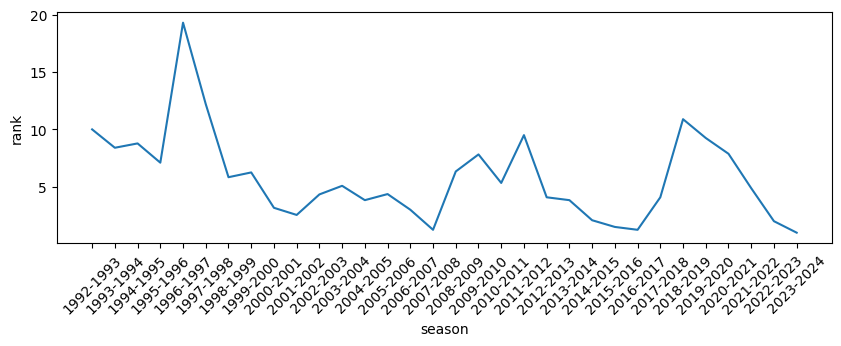

In [140]:
plt.figure(figsize=(10,3))
sns.lineplot(avg_rank_by_season.loc[avg_rank_by_season['country_abrv']=='ARG'], x='season',y='rank')
plt.xticks(rotation = 45)
plt.show()

In [177]:
combined_df = combined_df.merge(avg_rank_by_season[['season','country_abrv','rank']],right_on=['season','country_abrv'],left_on=['Season','Nation_abr']) 

In [178]:
last_season_df = last_season_df.merge(avg_rank_by_season[['season','country_abrv','rank']],right_on=['season','country_abrv'],left_on=['Season','Nation_abr']) 

In [179]:
combined_df = combined_df.rename(columns={'rank':'nation_rank'})
last_season_df = last_season_df.rename(columns={'rank':'nation_rank'})

## Prepare for modeling 

In [195]:
combined_df = combined_df.sort_values(by=["Player", "season"])
combined_df["next_season_league"] = combined_df.groupby("Player")["League"].shift(-1)


In [196]:
combined_df["next_season_league"] = combined_df["next_season_league"].fillna("Other/Out")


In [197]:
combined_df["next_season_league"].value_counts()

next_season_league
Other/Out              20740
Championship            6142
Brasileirao             5377
Premier League          5025
Serie A                 4928
La Liga                 4658
Liga MX                 4639
Ligue 1                 4344
Bundesliga              4062
Primeira Liga           4004
Belgian Pro League      3710
Eredivisie              3649
Liga Profesional        3186
Serie B                 2713
Austrian Bundesliga     2276
Name: count, dtype: int64

# EDA 

In [159]:
# Filter players who moved into Top 4 leagues
top_4_entries = combined_df[(combined_df['top_4'] == 1) &
                            (combined_df['previous_league'].notna()) &
                            (combined_df['previous_league'] != combined_df['League'])&
                             (combined_df['previous_league_top_4'] == False)]

top_4_entries = top_4_entries.sort_values(by ='Season')

top_4_entries_unique = top_4_entries.drop_duplicates(subset=['Player'],keep='first')

# Count movements from previous_league to current League
df_flow = top_4_entries_unique.groupby(['previous_league', 'League']).size().reset_index(name='count')

# Create label list for Sankey
labels = list(pd.unique(df_flow['previous_league'].tolist() + df_flow['League'].tolist()))

# Create index maps
label_index = {label: i for i, label in enumerate(labels)}

# Sankey data
sources = df_flow['previous_league'].map(label_index)
targets = df_flow['League'].map(label_index)
values = df_flow['count']

C:\Users\User\AppData\Local\Temp\ipykernel_181404\949945360.py:15: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



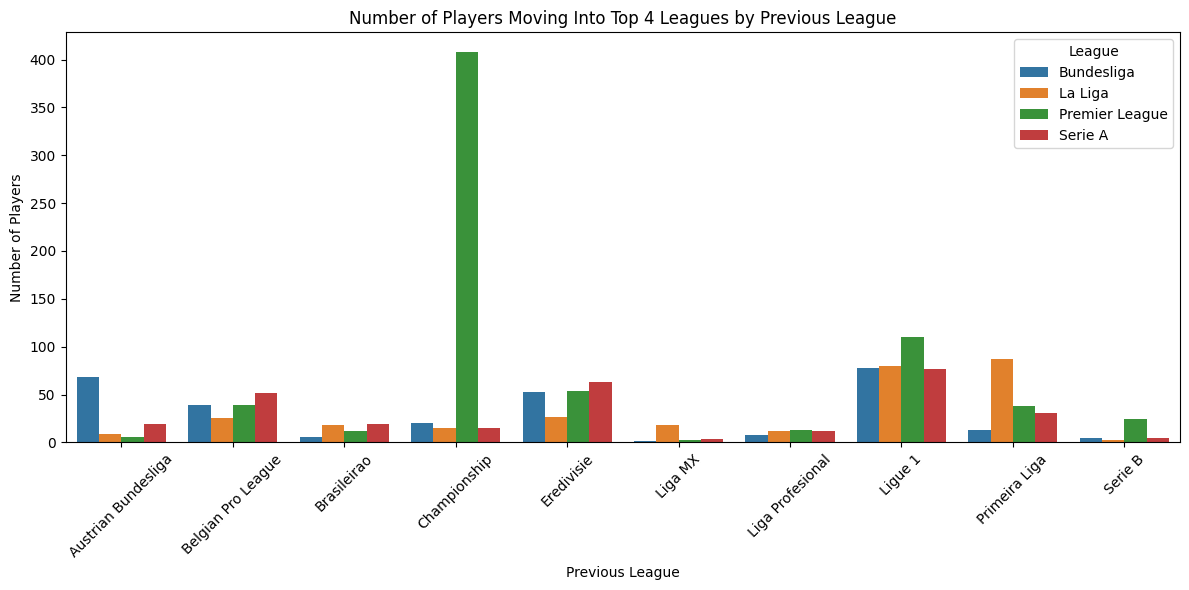

In [163]:
# Plot as grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=df_flow.loc[df_flow['previous_league']!= 0], x='previous_league', y='count', hue='League')

plt.title("Number of Players Moving Into Top 4 Leagues by Previous League")
plt.xlabel("Previous League")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [180]:
top_4_entries.loc[(top_4_entries['League'] == 'Premier League')&
                  (top_4_entries['Season']=='2023-2024')][['Player', 'Season','Squad','League','previous_league']]

,Player,Season,Squad,League,previous_league
4843,Andrey Santos,2023-2024,Nott'ham Forest,Premier League,0
4801,Andrew Omobamidele,2023-2024,Nott'ham Forest,Premier League,Championship
76607,Wilson Odobert,2023-2024,Burnley,Premier League,Ligue 1
4156,Anass Zaroury,2023-2024,Burnley,Premier League,Belgian Pro League
79349,Đorđe Petrović,2023-2024,Chelsea,Premier League,0
...,...,...,...,...,...
65025,Ross Barkley,2023-2024,Luton Town,Premier League,Ligue 1
66478,Sam Curtis,2023-2024,Sheffield Utd,Premier League,0
65861,Ryan One,2023-2024,Sheffield Utd,Premier League,0
65745,Ryan Giles,2023-2024,Luton Town,Premier League,Championship


In [184]:
combined_df.loc[combined_df['Player']=='Andrey Santos']

,Unnamed: 0,Rk,Player,Nation,Pos,Squad,Age,Born,Playing Time MP,Playing Time Starts,...,Per 90 Minutes xG+xAG,Per 90 Minutes npxG,Per 90 Minutes npxG+xAG,Nation_abr,top_4,previous_league,previous_league_top_4,season,country_abrv,nation_rank
4843,5895,476,Andrey Santos,br BRA,MF,Nott'ham Forest,19.0,2004.0,1,0,...,0.64,0.64,0.64,BRA,True,NaN,NaN,2023-2024,BRA,4.125
4844,30422,456,Andrey Santos,br BRA,MF,Strasbourg,19.0,2004.0,11,9,...,0.21,0.11,0.21,BRA,False,Premier League,True,2023-2024,BRA,4.125


In [185]:
transitions_age = top_4_entries.loc[top_4_entries['previous_league'] == 'Championship'][['Player','Season','Age','League','previous_league']]

In [186]:
transitions_age['Player'].nunique()

730

In [188]:
transitions_age.loc[transitions_age['Player'] == 'Aboubakar Kamara']

,Player,Season,Age,League,previous_league
481,Aboubakar Kamara,2018-2019,23.0,Premier League,Championship
483,Aboubakar Kamara,2020-2021,25.0,Premier League,Championship


In [189]:
transitions_age = transitions_age.drop_duplicates(subset=['Player'])

In [190]:
transitions_age

,Player,Season,Age,League,previous_league
40901,Kevin Long,2014-2015,23.0,Premier League,Championship
73724,Tyias Browning,2014-2015,20.0,Premier League,Championship
10560,Callum McManaman,2014-2015,23.0,Premier League,Championship
56366,Niko Kranjčar,2014-2015,29.0,Premier League,Championship
40828,Kevin Doyle,2014-2015,30.0,Premier League,Championship
...,...,...,...,...,...
66957,Sander Berge,2023-2024,25.0,Premier League,Championship
20375,Elijah Adebayo,2023-2024,25.0,Premier League,Championship
22552,Famara Diedhiou,2023-2024,30.0,La Liga,Championship
24632,Fred Onyedinma,2023-2024,26.0,Premier League,Championship


<Axes: xlabel='Age', ylabel='Count'>

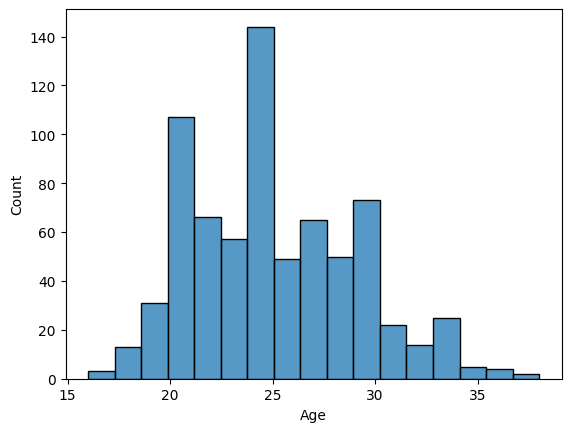

In [191]:
sns.histplot(transitions_age['Age'])

## Model

In [193]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79453 entries, 0 to 79452
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               79453 non-null  int64  
 1   Rk                       79453 non-null  int64  
 2   Player                   79453 non-null  object 
 3   Nation                   79453 non-null  object 
 4   Pos                      79453 non-null  object 
 5   Squad                    79453 non-null  object 
 6   Age                      73601 non-null  float64
 7   Born                     79453 non-null  float64
 8   Playing Time MP          79453 non-null  int64  
 9   Playing Time Starts      79453 non-null  int64  
 10  Playing Time Min         79453 non-null  float64
 11  Playing Time 90s         79453 non-null  float64
 12  Performance Gls          79453 non-null  float64
 13  Performance Ast          79453 non-null  float64
 14  Performance G+A       

In [194]:
combined_df['Season'].unique()

array(['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022',
       '2014-2015', '2023-2024', '2016-2017', '2022-2023', '2013-2014',
       '2015-2016'], dtype=object)

In [ ]:
# Model
